In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import nltk
nltk.download('punkt')
import matplotlib.pyplot as plt
import json
from collections import defaultdict
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from string import punctuation
from numpy.linalg import norm
import tensorflow as tf
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
lemmatizer= WordNetLemmatizer()

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
#df_train= pd.read_json("snli_1.0_train.jsonl", lines=True)
#df_test= pd.read_json("snli_1.0_test.jsonl", lines=True)
#df_validation= pd.read_json("snli_1.0_dev.jsonl", lines=True)
!curl -LO https://raw.githubusercontent.com/MohamadMerchant/SNLI/master/data.tar.gz
!tar -xvzf data.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 11.1M  100 11.1M    0     0  6630k      0  0:00:01  0:00:01 --:--:-- 6630k
SNLI_Corpus/
SNLI_Corpus/snli_1.0_dev.csv
SNLI_Corpus/snli_1.0_train.csv
SNLI_Corpus/snli_1.0_test.csv


In [ ]:
df_train = pd.read_csv("SNLI_Corpus/snli_1.0_train.csv")
df_valid = pd.read_csv("SNLI_Corpus/snli_1.0_dev.csv")
df_test = pd.read_csv("SNLI_Corpus/snli_1.0_test.csv")
#df_t1=pd.read_json("multinli_1.0_dev_mismatched.jsonl", lines=True)

In [ ]:
df_train.dropna(axis=0, inplace=True)

In [ ]:
df_train = (
    df_train[df_train.similarity != "-"]
    .sample(frac=1.0, random_state=42) #modificato valore da 42 a 0 di random state
    .reset_index(drop=True)
)

df_train = (
    df_train[df_train.similarity != "neutral"]
    .sample(frac=1.0, random_state=42)
    .reset_index(drop=True)
)

df_valid = (
    df_valid[df_valid.similarity != "-"]
    .sample(frac=1.0, random_state=42)
    .reset_index(drop=True)
)

df_valid = (
    df_valid[df_valid.similarity != "neutral"]
    .sample(frac=1.0, random_state=42)
    .reset_index(drop=True)
)

df_test = (
    df_test[df_test.similarity !='-']
    .sample(frac=1.0, random_state=42)
    .reset_index(drop=True)
)

df_test = (
    df_test[df_test.similarity !='neutral']
    .sample(frac=1.0, random_state=42)
    .reset_index(drop=True)
)

In [ ]:
df_train["label"] = df_train["similarity"].apply(
    lambda x: 0 if x == "contradiction" else 1
)
#y_train = tf.keras.utils.to_categorical(df_train.label, num_classes=2)

df_valid["label"] = df_valid["similarity"].apply(
    lambda x: 0 if x == "contradiction" else 1 
)
#y_val = tf.keras.utils.to_categorical(df_valid.label, num_classes=2)

df_test["label"] = df_test["similarity"].apply(
    lambda x: 0 if x == "contradiction" else 1 
)
#y_test = tf.keras.utils.to_categorical(df_test.label, num_classes=2)

In [4]:
#estrazione di gold_label, sentence1 e sentence2 in una lista
def list_extractor(dataframe, label):
  return dataframe[label].tolist()

In [ ]:
sentence1_train= list_extractor(df_train, 'sentence1')
sentence2_train= list_extractor(df_train, 'sentence2')
label_train= df_train['label'].tolist()

In [ ]:
sentence1_test= list_extractor(df_test, 'sentence1')
sentence2_test= list_extractor(df_test, 'sentence2')
#label_test= df_test['label'].tolist()

In [ ]:
sentence1_validation= list_extractor(df_valid, 'sentence1')
sentence2_validation= list_extractor(df_valid, 'sentence2')
#label_validation= df_valid['label'].tolist()

In [5]:
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
stopws=['of', 'from', 'the', 'a', 'an', 'at','with','and','or','o','(',')','uh','um','but']
def tokenize(text):
  return[lemmatizer.lemmatize(x.lower()) for x in nltk.word_tokenize(text) if x not in punctuation and x not in stopws]
#nltk_tokenize= lambda text: [x.lower() for x in nltk.word_tokenize(text) if x not in punctuation]

In [7]:
from nltk import pos_tag
from nltk.corpus import wordnet as wn 
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

In [9]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
def bag_of_words(sentence1, sentence2):
  try:
    CountVec = CountVectorizer(ngram_range=(1,1), stop_words=stopws)
    Count_data = CountVec.fit_transform([sentence1,sentence2])
    b1=Count_data[0].toarray()
    b2=Count_data[1].toarray()
    cosine= cosine_similarity(b1,b2).flatten()
  except:
    return 0.
  return cosine

In [ ]:
list_cosine_bow=[bag_of_words(sentence1_train[i],sentence2_train[i])for i in range(len(sentence1_train))]

In [ ]:
#count occurrencies
def count_freq(text,i,hypothesis):
  token_text= tokenize(text[i])
  token_hyp= tokenize(hypothesis[i])
  bow1= defaultdict(lambda: 0)
  bow2= defaultdict(lambda: 0)
  for key in token_text:
    bow1[key] +=1
    if key in token_hyp:
      bow2[key] +=1
    else:
      bow2[key] = 0

  b1=[x for x in bow1.values()]
  b2=[x for x in bow2.values()]
  cosine=cosine_similarity(b1,b2)
  return cosine

In [10]:
from numpy.linalg import norm

In [11]:
nltk.download('wordnet')
nltk.download('omw-1.4')
from itertools import product

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
#cosine values for train
list_cosine=[]
for i in range(len(sentence1_train)):
  list_cosine.append(count_freq(sentence1_train,i,sentence2_train))

In [ ]:
#cosine values for train
cosine_values=[]
for i in range(len(list_cosine)):
  cosine_values.append(list_cosine[i])

In [ ]:
#cosine values for test
list_cosine_test=[]
for i in range(len(sentence1_test)):
  list_cosine_test.append(count_freq(sentence1_test,i,sentence2_test))

In [ ]:
#cosine values for test
cosine_values_test=[]
for i in range(len(list_cosine_test)):
  cosine_values_test.append(list_cosine_test[i])

In [ ]:
#cosine values for validation
list_cosine_validation=[]
for i in range(len(sentence1_validation)):
  list_cosine_validation.append(count_freq(sentence1_validation,i,sentence2_validation))

In [ ]:
#cosine values for validation
cosine_values_validation=[]
for i in range(len(list_cosine_validation)):
  cosine_values_validation.append(list_cosine_validation[i])

In [12]:
import gensim

In [13]:
from gensim.models import KeyedVectors

SIMILARITY USING GENSIM

In [14]:
import gensim.downloader as api
wv = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [15]:
def func(sentence1, sentence2): #calcola la similarity utilizzando gensim
  pairs=[]
  tokens1= tokenize(sentence1)
  tokens2= tokenize(sentence2)
  pairs=[[(tokens1[i], tokens2[j]) for j in range(len(tokens2))] for i in range(len(tokens1))]
  
  list_sim=[]
  sum_similarity=0
  n, max, count= 0, 0, 0
  for i in range(len(pairs)):
      for t1,t2 in pairs[i]:
        try:
          list_sim.append(wv.similarity(t1,t2))
          
          count +=1
          
          if count == len(tokens2):
            count= 0
            max= list_sim[0]
            for j in range(len(list_sim)):
              if max < list_sim[j]:
                max=list_sim[j]
            list_sim.clear()
            sum_similarity += max
            n+= 1
        except:
            pass
  
  if n == 0:
    return 0.001
  return sum_similarity/n
  

In [ ]:
#similarity gensim for train
sim_gensim_train=[]
for i in range(len(sentence1_train)):
  sim_gensim_train.append(func(sentence1_train[i], sentence2_train[i])) 

In [ ]:
#similarity gensim for test
sim_gensim_test=[]
for i in range(len(sentence1_test)):
  sim_gensim_test.append(func(sentence1_test[i], sentence2_test[i])) 

In [ ]:
#similarity gensim for validation
sim_gensim_validation=[]
for i in range(len(sentence1_validation)):
  sim_gensim_validation.append(func(sentence1_validation[i], sentence2_validation[i]))

SIMILARITY USING SPACY

In [16]:
import spacy.cli
spacy.cli.download("en_core_web_lg")
nlp = spacy.load("en_core_web_lg")

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [17]:
def similarity_spacy(sentence1, sentence2):
  s1=nlp(sentence1) #vectorize tokens
  s2=nlp(sentence2) #vectorize tokens
  similarity=0.001
  if (s1 and s1.vector_norm) and (s2 and s2.vector_norm): #check if s1 and s2 is valid and the vector is valid (Error: Evaluating Doc.similarity based on empty vectors.)
    similarity= s1.similarity(s2)
  return similarity


In [ ]:
nlp.pipe_names

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']

In [ ]:
#similarity train with spacy
sim_spacy=[]
for i in range(len(sentence1_train)):
  sim_spacy.append(similarity_spacy(sentence1_train[i], sentence2_train[i]))

In [ ]:
#similarity test with spacy
sim_spacy_test=[] 
for i in range(len(sentence1_test)):
  sim_spacy_test.append(similarity_spacy(sentence1_test[i], sentence2_test[i]))

In [ ]:
#similarity validation with spacy
sim_spacy_validation=[]
for i in range(len(sentence1_validation)):
  sim_spacy_validation.append(similarity_spacy(sentence1_validation[i], sentence2_validation[i]))

SIMILARITY USING WORDNET

In [18]:
def penn_to_wn(tag):
    """ Convert between a Penn Treebank tag to a simplified Wordnet tag """
    if tag.startswith('N'):
        return 'n'
 
    if tag.startswith('V'):
        return 'v'
 
    if tag.startswith('J'):
        return 'a'
 
    if tag.startswith('R'):
        return 'r'
 
    return None
 
def tagged_to_synset(word, tag):
    wn_tag = penn_to_wn(tag)
    if wn_tag is None:
        return None
 
    try:
        return wn.synsets(word, wn_tag)[0]
    except:
        return None
 
def sentence_similarity(sentence1, sentence2):
    """ compute the sentence similarity using Wordnet """
    # Tokenize and tag
    sentence1 = pos_tag(tokenize(sentence1))
    sentence2 = pos_tag(tokenize(sentence2))
 
    # Get the synsets for the tagged words
    synsets1 = [tagged_to_synset(*tagged_word) for tagged_word in sentence1]
    synsets2 = [tagged_to_synset(*tagged_word) for tagged_word in sentence2]
 
    # Filter out the Nones
    synsets1 = [ss for ss in synsets1 if ss]
    synsets2 = [ss for ss in synsets2 if ss]
    score, count = 0.0, 0
    # For each word in the first sentence
    for synset in synsets1:
      try:
        # Get the similarity value of the most similar word in the other sentence
        best_score = max([synset.wup_similarity(ss) for ss in synsets2])
      except:
        best_score=0
        # Check that the similarity could have been computed
      if best_score is not None:
            score += best_score
            count += 1
    # Average the values
    if count == 0:
      return 0.001
    score /= count
    return score

In [19]:
def symmetric_sentence_similarity(sentence1, sentence2):
    """ compute the symmetric sentence similarity using Wordnet """
    return (sentence_similarity(sentence1, sentence2) + sentence_similarity(sentence2, sentence1)) / 2 

In [ ]:
#compute similarity with wordnet for train
similarity_sentences=[]
for i in range(len(sentence1_train)):
  similarity_sentences.append(symmetric_sentence_similarity(sentence1_train[i], sentence2_train[i]))

In [ ]:
#compute similarity with wordnet for test set
similarity_sentences_test=[]
for i in range(len(sentence1_test)):
  similarity_sentences_test.append(symmetric_sentence_similarity(sentence1_test[i], sentence2_test[i]))

In [ ]:
#compute similarity with wordnet for validation set
similarity_sentences_validation=[]
for i in range(len(sentence1_validation)):
  similarity_sentences_validation.append(symmetric_sentence_similarity(sentence1_validation[i], sentence2_validation[i]))

LEVENSHTEIN DISTANCE

In [20]:
!pip install python-Levenshtein

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 4.4 MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-linux_x86_64.whl size=149865 sha256=bfc6351d5db10aae4cd6fb6b6ce064b60cc2362415dd69d9434bbe7771f20b04
  Stored in directory: /root/.cache/pip/wheels/05/5f/ca/7c4367734892581bb5ff896f15027a932c551080b2abd3e00d
Successfully built python-Levenshtein


In [21]:
from Levenshtein import distance as lev

In [22]:
def lev_distance(sentence1, sentence2):
  pairs=[]
  tokens1= tokenize(sentence1)
  tokens2= tokenize(sentence2)
  pairs=[[(tokens1[i], tokens2[j]) for j in range(len(tokens2))] for i in range(len(tokens1))]
  
  list_diff=[]
  sum_diff=0
  n, min, count= 0, 0, 0
  list_diff=[]
  for i in range(len(pairs)):
      for t1,t2 in pairs[i]:
        try:
          list_diff.append(lev(t1,t2))
          
          count +=1
          
          if count == len(tokens2):
            count= 0
            min= list_diff[0]
            for j in range(len(list_diff)):
              if min > list_diff[j]:
                min=list_diff[j]
            list_diff.clear()
            sum_diff += min
            n+= 1
        except:
            pass
  if n == 0:
    return 0.001
  return sum_diff/n

In [ ]:
#leveshtein distance
lev_distance_train=[]
for i in range(len(sentence1_train)):
  lev_distance_train.append(lev_distance(sentence1_train[i], sentence2_train[i]))

'''lev_distance_test=[]
for i in range(len(sentence1_test)):
  lev_distance_test.append(lev_distance(sentence1_test[i], sentence2_test[i]))

lev_distance_val=[]
for i in range(len(sentence1_validation)):
  lev_distance_val.append(lev_distance(sentence1_validation[i], sentence2_validation[i]))
'''

'lev_distance_test=[]\nfor i in range(len(sentence1_test)):\n  lev_distance_test.append(lev_distance(sentence1_test[i], sentence2_test[i]))\n\nlev_distance_val=[]\nfor i in range(len(sentence1_validation)):\n  lev_distance_val.append(lev_distance(sentence1_validation[i], sentence2_validation[i]))\n'

In [ ]:
#df_tr = pd.DataFrame(list_cosine_bow,columns=['cosine_sim'])
df_tr= pd.DataFrame(similarity_sentences,columns=['sim_wordnet'])
#df_tr['cosine_occ']= cosine_values
#df_tr['similarity_wordnet']=similarity_sentences
df_tr['similarity_spacy']= sim_spacy
df_tr['similarity_gensim']= sim_gensim_train
df_tr['lev_distance']= lev_distance_train
df_tr.head(5)

,sim_wordnet,similarity_spacy,similarity_gensim,lev_distance
0,0.827691,0.839532,0.592448,2.181818
1,0.611503,0.844615,0.580936,2.000000
2,0.632792,0.776112,0.484423,3.428571
3,0.740458,0.823708,0.438145,3.000000
4,0.358974,0.761575,0.307697,3.000000


In [23]:
from sklearn.preprocessing import StandardScaler

In [24]:
scale= StandardScaler()

NEURAL NETOWRK WITH SIMILARITY METRICS EXTRACTED

In [ ]:
X_train= df_tr[df_tr.columns[:]].values #valori del train

In [ ]:
scaled_data = scale.fit_transform(X_train)

In [ ]:
#X_test= df_te[df_te.columns[:]].values #valori x test

In [ ]:
#X_validation= df_val[df_val.columns[:]].values #valori x validation

In [44]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_temp, y_train, y_temp= train_test_split(X_train, label_train, test_size=0.3, random_state=42)
X_valid, X_test, y_valid, y_test= train_test_split(X_temp, y_temp, test_size=0.4, random_state=42)

In [ ]:
y_train= np.asarray(y_train) #valori label y per il train
#x_test= np.asarray(X_test) #valori x per il test
y_test=np.asarray(y_test) #valori y per il test
x_valid= np.asarray(X_valid) #valori x per validation
y_valid=np.asarray(y_valid) #valori y per validation

In [25]:
import tensorflow as tf


In [ ]:
model= tf.keras.Sequential([
                            tf.keras.layers.Dense(16, activation='softmax'), #layer di una dense NN, denso indica che un neurone prende come gli input da tutti i neuroni, con 16 neuroni
                            tf.keras.layers.Dense(16, activation='softmax'),
                            tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics= ['accuracy']
              )

In [ ]:
model.evaluate(X_train, y_train)

8020/8020 [==============================] - 12s 1ms/step - loss: 0.6963 - accuracy: 0.4995


[0.6963495016098022, 0.499549925327301]

In [ ]:
model.evaluate(X_valid, y_valid)

2063/2063 [==============================] - 3s 1ms/step - loss: 0.6963 - accuracy: 0.4997


[0.696323037147522, 0.4996514618396759]

In [ ]:
history= model.fit(X_train, y_train, batch_size=220, epochs=70, validation_data=(X_valid, y_valid)) #batch_size è il numero di samples che utilizziamo in ciascuna iterazione

Epoch 1/70
1167/1167 [==============================] - 3s 3ms/step - loss: 0.6793 - accuracy: 0.5780 - val_loss: 0.6634 - val_accuracy: 0.6067
Epoch 2/70
1167/1167 [==============================] - 3s 2ms/step - loss: 0.6629 - accuracy: 0.6079 - val_loss: 0.6575 - val_accuracy: 0.6169
Epoch 3/70
1167/1167 [==============================] - 3s 2ms/step - loss: 0.6557 - accuracy: 0.6201 - val_loss: 0.6482 - val_accuracy: 0.6311
Epoch 4/70
1167/1167 [==============================] - 3s 2ms/step - loss: 0.6459 - accuracy: 0.6329 - val_loss: 0.6409 - val_accuracy: 0.6377
Epoch 5/70
1167/1167 [==============================] - 3s 2ms/step - loss: 0.6409 - accuracy: 0.6355 - val_loss: 0.6386 - val_accuracy: 0.6371
Epoch 6/70
1167/1167 [==============================] - 3s 2ms/step - loss: 0.6391 - accuracy: 0.6365 - val_loss: 0.6372 - val_accuracy: 0.6393
Epoch 7/70
1167/1167 [==============================] - 3s 3ms/step - loss: 0.6382 - accuracy: 0.6365 - val_loss: 0.6371 - val_accuracy:

In [ ]:
model.evaluate(X_test, y_test)

1375/1375 [==============================] - 2s 1ms/step - loss: 0.6263 - accuracy: 0.6468


[0.6262719631195068, 0.6467539668083191]

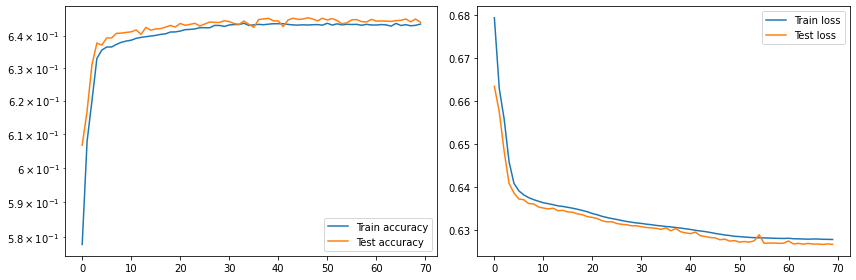

In [ ]:
#plot accuracy during training/validation
fig, ax = plt.subplots(figsize=(12, 4), ncols=2)
ax[0].plot(history.history['accuracy'], label='Train accuracy')
ax[0].plot(history.history['val_accuracy'], label='Test accuracy')
ax[0].set_yscale('log')
ax[0].legend()
ax[1].plot(history.history['loss'], label='Train loss')
ax[1].plot(history.history['val_loss'], label='Test loss')
ax[1].legend()
plt.tight_layout()
plt.show()

In [26]:
labels=['not entailment', 'entailment']

In [27]:
def check_similarity(sentence1, sentence2, model_used):
   X_train=[[func(sentence1,sentence2),similarity_spacy(sentence1,sentence2),
            symmetric_sentence_similarity(sentence1, sentence2),lev_distance(sentence1, sentence2)]]
   proba = model_used.predict(X_train)
   label = labels[proba[0]]
   return label

SUPPORT VECTOR MACHINE WITH FEATURES EXTRACTED

In [28]:
# demonstration of calculating metrics for a neural network model using sklearn
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense

In [29]:
from sklearn import svm

In [ ]:
#create a classifier
cls = svm.SVC(C= .1, kernel="rbf", gamma= 1)

#train the model
hist= cls.fit(X_train,y_train)

#predict the response
pred = cls.predict(X_test)

pred_train=cls.predict(X_train)

In [30]:
from sklearn import metrics as mt

In [ ]:
#accuracy
print("accuracy:", mt.accuracy_score(y_test, pred))
#precision score
print("precision:", mt.precision_score(y_test,pred))
#recall score
print("recall" , mt.recall_score(y_test,pred))
#auc
print("f1-score" , mt.f1_score(y_test,pred))
print("ROC AUC", roc_auc_score(y_test, pred))
print(mt.classification_report(y_test, pred))

accuracy: 0.6420940170940171
precision: 0.6574144294453713
recall 0.5917986528308756
f1-score 0.622883284232713
ROC AUC 0.6420391992583079
              precision    recall  f1-score   support

           0       0.63      0.69      0.66     22020
           1       0.66      0.59      0.62     21972

    accuracy                           0.64     43992
   macro avg       0.64      0.64      0.64     43992
weighted avg       0.64      0.64      0.64     43992



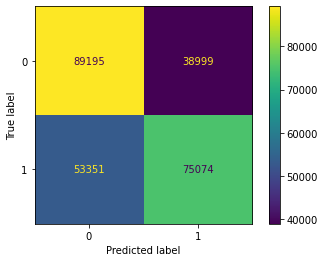

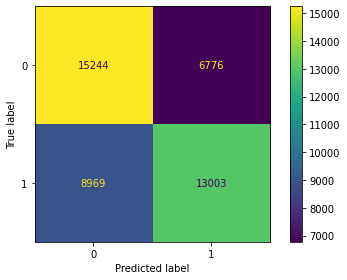

In [ ]:
#fig, ax = plt.subplots(figsize=(12, 6), ncols=1)
cmd_train = mt.ConfusionMatrixDisplay.from_predictions(y_train, pred_train, values_format='g')
#cmd_test = mt.ConfusionMatrixDisplay(confusion_matrix=mt.confusion_matrix(y_test, pred), values_format = '.5f')
cmd_test=mt.ConfusionMatrixDisplay.from_predictions(y_test, pred, values_format='g')
#cmd_train.plot(ax=ax[0], cmap='Greys', colorbar=False)
#cmd_test.plot(ax=ax, cmap='Greys', colorbar=False)
#ax[0].set_title('Trainset')
#ax.set_title('Testset')
plt.tight_layout()
plt.show()

In [ ]:
print(check_similarity('A soccer game with multiple males playing.','Some men are playing a sport.', cls))#wrong case

not entailment


In [ ]:
print(check_similarity('A man inspects the uniform of a figure in some East Asian country.','The man is sleeping', cls))

not entailment


In [ ]:
print(check_similarity('A black race car starts up in front of a crowd of people.','A man is driving down a lonely road.',cls))

not entailment


In [ ]:
print(check_similarity('Marco is going to go out to buy something','Marco will buy something', cls))

entailment


LOGISTIC REGRESSION

In [ ]:
df_tr = pd.DataFrame(similarity_sentences,columns=['sim_wordnet'])

In [ ]:
X=df_tr[df_tr.columns[:]].values

In [ ]:
X_tr, X_tmp, y_tr, y_tmp= train_test_split(X, label_train, test_size=0.3, random_state=0)
X_val, X_t, y_val, y_t= train_test_split(X_tmp, y_tmp, test_size=0.4, random_state=0)

In [ ]:
logmodel = LogisticRegression()
logmodel.fit(X_train, y_train)
predictions = logmodel.predict(X_test)
pred_train= logmodel.predict(X_train)

In [ ]:
print("precision:", mt.precision_score(y_test,predictions))
print("accuracy:", mt.accuracy_score(y_test, predictions))
print("recall" , mt.recall_score(y_test,predictions))
print("f1-score", mt.f1_score(y_test, predictions))
print("ROC AUC", roc_auc_score(y_test, predictions))


print(mt.classification_report(y_test, predictions))

precision: 0.6413710933919897
accuracy: 0.6407983269685398
recall 0.6369925359548516
f1-score 0.6391743161163629
ROC AUC 0.640794178967435
              precision    recall  f1-score   support

         0.0       0.64      0.64      0.64     22020
         1.0       0.64      0.64      0.64     21972

    accuracy                           0.64     43992
   macro avg       0.64      0.64      0.64     43992
weighted avg       0.64      0.64      0.64     43992



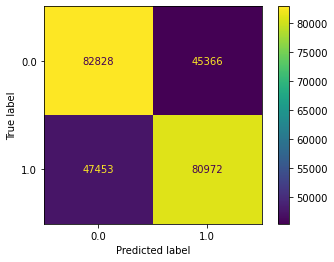

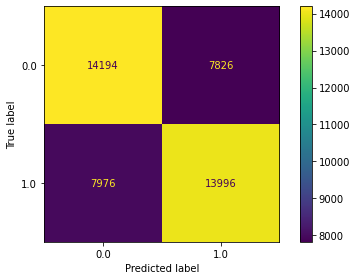

In [ ]:
#fig, ax = plt.subplots(figsize=(12, 6), ncols=1)
cmd_train = mt.ConfusionMatrixDisplay.from_predictions(y_train, pred_train, values_format='g')
#cmd_test = mt.ConfusionMatrixDisplay(confusion_matrix=mt.confusion_matrix(y_test, pred), values_format = '.5f')
cmd_test=mt.ConfusionMatrixDisplay.from_predictions(y_test, predictions, values_format='g')
#cmd_train.plot(ax=ax[0], cmap='Greys', colorbar=False)
#cmd_test.plot(ax=ax, cmap='Greys', colorbar=False)
#ax[0].set_title('Trainset')
#ax.set_title('Testset')
plt.tight_layout()
plt.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


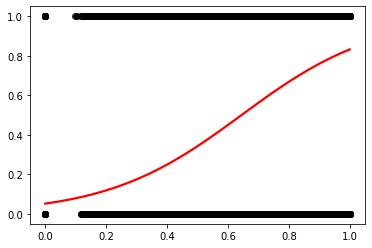

In [ ]:
sns.regplot(x=X_tr, y=y_tr, data=df_tr, logistic=True, ci=None, scatter_kws={'color': 'black'}, line_kws={'color': 'red'})

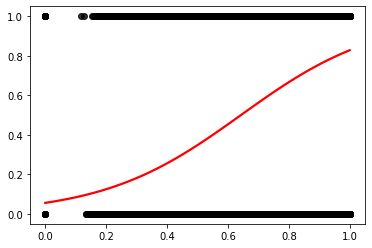

In [ ]:
sns.regplot(x=X_t, y=y_t, data=df_tr, logistic=True, ci=None, scatter_kws={'color': 'black'}, line_kws={'color': 'red'})

KNN

In [31]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 13)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=13)

In [ ]:
pred_train= knn.predict(X_train)

In [ ]:
prediction_knn = knn.predict(X_test)

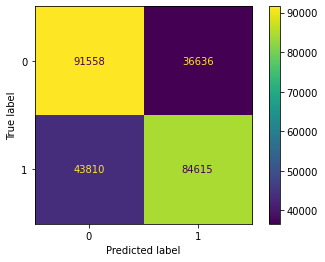

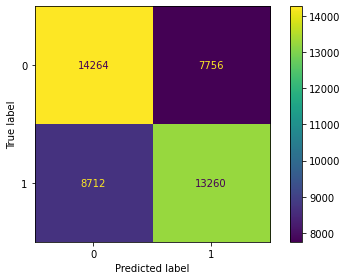

precision: 0.6309478492577084
accuracy: 0.6256592107655937
recall 0.6034953577280174
f1-score 0.6169163487484879
ROC AUC 0.6256350539775419
              precision    recall  f1-score   support

           0       0.62      0.65      0.63     22020
           1       0.63      0.60      0.62     21972

    accuracy                           0.63     43992
   macro avg       0.63      0.63      0.63     43992
weighted avg       0.63      0.63      0.63     43992



In [ ]:
cmd_train = mt.ConfusionMatrixDisplay.from_predictions(y_train, pred_train, values_format='g')
cmd_test=mt.ConfusionMatrixDisplay.from_predictions(y_test, prediction_knn, values_format='g')
plt.tight_layout()
plt.show()

print("precision:", mt.precision_score(y_test,prediction_knn))
print("accuracy:", mt.accuracy_score(y_test, prediction_knn))
print("recall" , mt.recall_score(y_test,prediction_knn))
print("f1-score", mt.f1_score(y_test, prediction_knn))
print("ROC AUC", roc_auc_score(y_test, prediction_knn))
print(classification_report(y_test, prediction_knn))

In [ ]:
print(check_similarity('Tim has bought fish tonight','Tim has spent money tonight', knn)) #wrong case

not entailment


In [ ]:
print(check_similarity('Tim has bought fish tonight','Tim has bought something', knn))

entailment


TEST WITH MNLI DATASET

In [32]:
df_train= pd.read_json("multinli_1.0_train.jsonl", lines=True)

In [33]:
df_train.dropna(axis=0, inplace=True)

df_train = (
    df_train[df_train.gold_label != "-"]
    .sample(frac=1.0, random_state=42)
    .reset_index(drop=True)
)

df_train = (
    df_train[df_train.gold_label != "neutral"]
    .sample(frac=1.0, random_state=42)
    .reset_index(drop=True)
)

In [34]:
df_train["label"] = df_train["gold_label"].apply(
    lambda x: 0 if x == "contradiction" else 1
)

In [35]:
sentence1_train= list_extractor(df_train, 'sentence1')
sentence2_train= list_extractor(df_train, 'sentence2')
label_train= df_train['label'].tolist()

In [ ]:
#cosine values for train
list_cosine=[]
for i in range(len(sentence1_train)):
  list_cosine.append(count_freq(sentence1_train,i,sentence2_train))

#cosine values for train
cosine_values=[]
for i in range(len(list_cosine)):
  cosine_values.append(list_cosine[i])

NameError: ignored

In [ ]:
#cosine bow for train
list_cosine_bow=[bag_of_words(sentence1_train[i],sentence2_train[i])for i in range(len(sentence1_train))]

In [36]:
#similarity gensim for train
sim_gensim_train=[]
for i in range(len(sentence1_train)):
  sim_gensim_train.append(func(sentence1_train[i], sentence2_train[i])) 

In [37]:
#similarity train with spacy
sim_spacy=[]
for i in range(len(sentence1_train)):
  sim_spacy.append(similarity_spacy(sentence1_train[i], sentence2_train[i]))

In [38]:
#compute similarity with wordnet for train
similarity_sentences=[]
for i in range(len(sentence1_train)):
  similarity_sentences.append(symmetric_sentence_similarity(sentence1_train[i], sentence2_train[i]))

In [39]:
#leveshtein distance
lev_distance_train=[]
for i in range(len(sentence1_train)):
  lev_distance_train.append(lev_distance(sentence1_train[i], sentence2_train[i]))

In [40]:
#df_tr = pd.DataFrame(list_cosine_bow,columns=['cosine_sim'])
#df_tr['cosine_occ']= cosine_values
df_tr= pd.DataFrame(similarity_sentences, columns=['sim_wordnet'])
#df_tr['similarity_wordnet']=similarity_sentences
df_tr['similarity_spacy']= sim_spacy
df_tr['similarity_gensim']= sim_gensim_train
df_tr['lev_distance']= lev_distance_train
df_tr.head(5)

,sim_wordnet,similarity_spacy,similarity_gensim,lev_distance
0,0.715278,0.818720,0.742434,2.666667
1,0.813888,0.891022,0.605123,1.933333
2,0.515192,0.813605,0.368257,2.473684
3,0.466382,0.773367,0.358047,3.285714
4,0.685245,0.864092,0.734841,2.263158


NEURAL NETWORK

In [65]:
X_train= df_tr[df_tr.columns[:]].values #valori del train

In [66]:
scaled_data = scale.fit_transform(X_train)

In [67]:
X_train, X_temp, y_train, y_temp= train_test_split(X_train, label_train, test_size=0.4, random_state=42)
X_valid, X_test, y_valid, y_test= train_test_split(X_temp, y_temp, test_size=0.4, random_state=42)

In [68]:
y_train= np.asarray(y_train) #valori label y per il train
#x_test= np.asarray(X_test) #valori x per il test
y_test=np.asarray(y_test) #valori y per il test
x_valid= np.asarray(X_valid) #valori x per validation
y_valid=np.asarray(y_valid) #valori y per validation

In [121]:
model1= tf.keras.Sequential([
                            tf.keras.layers.Dense(16, activation='softmax'), #layer di una dense NN, denso indica che un neurone prende come gli input da tutti i neuroni, con 16 neuroni
                            tf.keras.layers.Dense(16, activation='softmax'),
                            tf.keras.layers.Dense(1, activation='sigmoid')
])

In [122]:
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics= ['accuracy']
              )

In [123]:
model1.evaluate(X_train, y_train)

4909/4909 [==============================] - 7s 1ms/step - loss: 0.6955 - accuracy: 0.5000


[0.695500373840332, 0.5000413656234741]

In [124]:
model1.evaluate(X_valid, y_valid)

1964/1964 [==============================] - 4s 2ms/step - loss: 0.6955 - accuracy: 0.5001


[0.6954891681671143, 0.5001273155212402]

In [125]:
history= model1.fit(X_train, y_train, batch_size=180, epochs=70, validation_data=(X_valid, y_valid)) #batch_size è il numero di samples che utilizziamo in ciascuna iterazione

Epoch 1/70
873/873 [==============================] - 3s 3ms/step - loss: 0.6834 - accuracy: 0.5756 - val_loss: 0.6687 - val_accuracy: 0.5968
Epoch 2/70
873/873 [==============================] - 2s 2ms/step - loss: 0.6667 - accuracy: 0.5988 - val_loss: 0.6654 - val_accuracy: 0.5977
Epoch 3/70
873/873 [==============================] - 2s 2ms/step - loss: 0.6647 - accuracy: 0.6013 - val_loss: 0.6633 - val_accuracy: 0.6008
Epoch 4/70
873/873 [==============================] - 2s 3ms/step - loss: 0.6624 - accuracy: 0.6044 - val_loss: 0.6609 - val_accuracy: 0.6043
Epoch 5/70
873/873 [==============================] - 2s 3ms/step - loss: 0.6601 - accuracy: 0.6075 - val_loss: 0.6586 - val_accuracy: 0.6085
Epoch 6/70
873/873 [==============================] - 2s 2ms/step - loss: 0.6581 - accuracy: 0.6106 - val_loss: 0.6569 - val_accuracy: 0.6111
Epoch 7/70
873/873 [==============================] - 2s 3ms/step - loss: 0.6568 - accuracy: 0.6133 - val_loss: 0.6558 - val_accuracy: 0.6132
Epoch 

In [126]:
model1.evaluate(X_test, y_test)

1310/1310 [==============================] - 2s 1ms/step - loss: 0.6495 - accuracy: 0.6228


[0.6494836807250977, 0.6228126883506775]

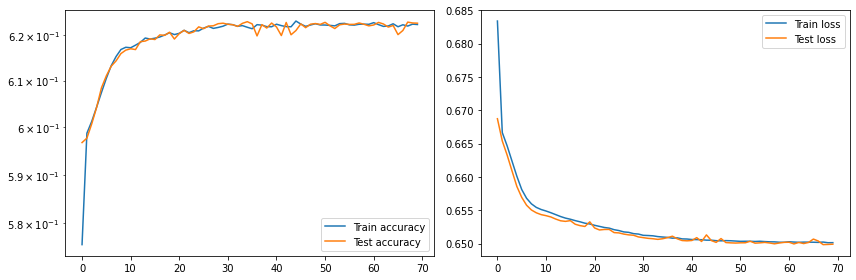

In [127]:
#plot accuracy during training/validation
fig, ax = plt.subplots(figsize=(12, 4), ncols=2)
ax[0].plot(history.history['accuracy'], label='Train accuracy')
ax[0].plot(history.history['val_accuracy'], label='Test accuracy')
ax[0].set_yscale('log')
ax[0].legend()
ax[1].plot(history.history['loss'], label='Train loss')
ax[1].plot(history.history['val_loss'], label='Test loss')
ax[1].legend()
plt.tight_layout()
plt.show()

SVM

In [76]:
#create a classifier
cls = svm.SVC(C= .1, kernel="rbf", gamma= 1)

#train the model
hist= cls.fit(X_train,y_train)

#predict the response
pred = cls.predict(X_test)

pred_train=cls.predict(X_train)

In [77]:
#accuracy
print("accuracy:", mt.accuracy_score(y_test, pred))
#precision score
print("precision:", mt.precision_score(y_test,pred))
#recall score
print("recall" , mt.recall_score(y_test,pred))
#auc
print("f1-score", mt.f1_score(y_test, pred))
print("ROC AUC", roc_auc_score(y_test, pred))
print(mt.classification_report(y_test, pred))

accuracy: 0.6183723650600397
precision: 0.6242563615457681
recall 0.5958390991076967
f1-score 0.609716796875
ROC AUC 0.6183858212909017
              precision    recall  f1-score   support

           0       0.61      0.64      0.63     20932
           1       0.62      0.60      0.61     20957

    accuracy                           0.62     41889
   macro avg       0.62      0.62      0.62     41889
weighted avg       0.62      0.62      0.62     41889



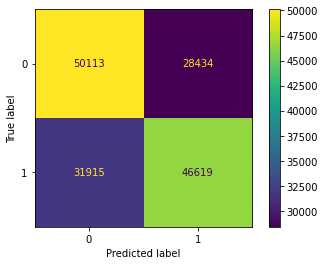

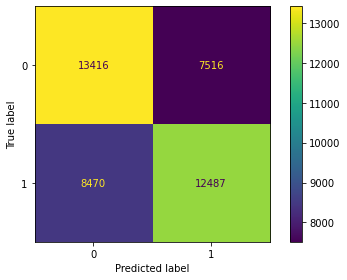

In [78]:
#fig, ax = plt.subplots(figsize=(12, 6), ncols=1)
cmd_train = mt.ConfusionMatrixDisplay.from_predictions(y_train, pred_train, values_format='g')
#cmd_test = mt.ConfusionMatrixDisplay(confusion_matrix=mt.confusion_matrix(y_test, pred), values_format = '.5f')
cmd_test=mt.ConfusionMatrixDisplay.from_predictions(y_test, pred, values_format='g')
#cmd_train.plot(ax=ax[0], cmap='Greys', colorbar=False)
#cmd_test.plot(ax=ax, cmap='Greys', colorbar=False)
#ax[0].set_title('Trainset')
#ax.set_title('Testset')
plt.tight_layout()
plt.show()

In [79]:
print(check_similarity('A soccer game with multiple males playing.','Some men are playing a sport.', cls))#wrong case

not entailment


In [80]:
print(check_similarity('A man inspects the uniform of a figure in some East Asian country.','The man is sleeping', cls))

not entailment


In [81]:
print(check_similarity('Marco is going to go out to buy something','Marco will buy something', cls))

entailment


LOGISTIC REGRESSION

In [82]:
logmodel = LogisticRegression()
logmodel.fit(X_train, y_train)
predictions = logmodel.predict(X_test)
pred_train= logmodel.predict(X_train)

In [83]:
print("precision:", mt.precision_score(y_test,predictions))
print("accuracy:", mt.accuracy_score(y_test, predictions))
print("recall" , mt.recall_score(y_test,predictions))
print("f1-score", mt.f1_score(y_test, predictions))
print("ROC AUC", roc_auc_score(y_test, predictions))

print(mt.classification_report(y_test, predictions))

precision: 0.6189330896147001
accuracy: 0.6177516770512546
recall 0.6139714653814955
f1-score 0.6164422938724669
ROC AUC 0.6177539344870404
              precision    recall  f1-score   support

           0       0.62      0.62      0.62     20932
           1       0.62      0.61      0.62     20957

    accuracy                           0.62     41889
   macro avg       0.62      0.62      0.62     41889
weighted avg       0.62      0.62      0.62     41889



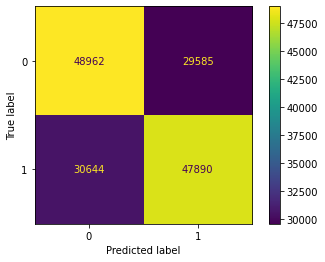

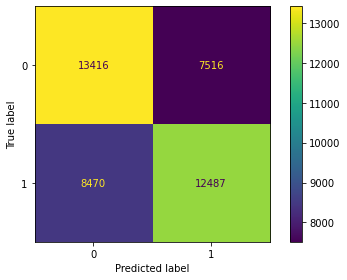

In [84]:
#fig, ax = plt.subplots(figsize=(12, 6), ncols=1)
cmd_train = mt.ConfusionMatrixDisplay.from_predictions(y_train, pred_train, values_format='g')
#cmd_test = mt.ConfusionMatrixDisplay(confusion_matrix=mt.confusion_matrix(y_test, pred), values_format = '.5f')
cmd_test=mt.ConfusionMatrixDisplay.from_predictions(y_test, pred, values_format='g')
#cmd_train.plot(ax=ax[0], cmap='Greys', colorbar=False)
#cmd_test.plot(ax=ax, cmap='Greys', colorbar=False)
#ax[0].set_title('Trainset')
#ax.set_title('Testset')
plt.tight_layout()
plt.show()

In [ ]:
df_tr = pd.DataFrame(similarity_sentences,columns=['sim_wordnet'])

In [ ]:
X=df_tr[df_tr.columns[:]].values

In [ ]:
X_tr, X_tmp, y_tr, y_tmp= train_test_split(X, label_train, test_size=0.3, random_state=0)
X_val, X_t, y_val, y_t= train_test_split(X_tmp, y_tmp, test_size=0.4, random_state=0)

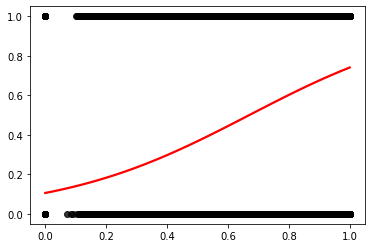

In [ ]:
sns.regplot(x=X_tr, y=y_tr, data=df_tr, logistic=True, ci=None, scatter_kws={'color': 'black'}, line_kws={'color': 'red'})

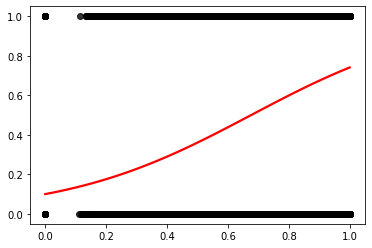

In [ ]:
sns.regplot(x=X_t, y=y_t, data=df_tr, logistic=True, ci=None, scatter_kws={'color': 'black'}, line_kws={'color': 'red'})

KNN

In [118]:
knn = KNeighborsClassifier(n_neighbors = 21)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=21)

In [119]:
prediction_knn = knn.predict(X_test)
prediction_train= knn.predict(X_train)

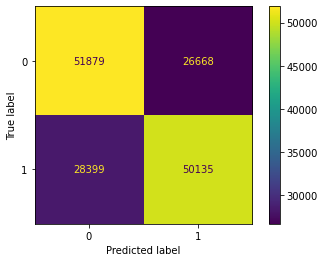

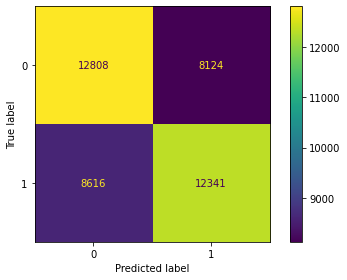

precision: 0.6030295626679697
accuracy: 0.6003724128052711
recall 0.5888724531182898
f1-score 0.5958669306165806
ROC AUC 0.6003792802568327
              precision    recall  f1-score   support

           0       0.60      0.61      0.60     20932
           1       0.60      0.59      0.60     20957

    accuracy                           0.60     41889
   macro avg       0.60      0.60      0.60     41889
weighted avg       0.60      0.60      0.60     41889



In [120]:
cmd_train = mt.ConfusionMatrixDisplay.from_predictions(y_train, prediction_train, values_format='g')
cmd_test=mt.ConfusionMatrixDisplay.from_predictions(y_test, prediction_knn, values_format='g')
plt.tight_layout()
plt.show()

print("precision:", mt.precision_score(y_test,prediction_knn))
print("accuracy:", mt.accuracy_score(y_test, prediction_knn))
print("recall" , mt.recall_score(y_test,prediction_knn))
print("f1-score", mt.f1_score(y_test, prediction_knn))
print("ROC AUC", roc_auc_score(y_test, prediction_knn))
print(classification_report(y_test, prediction_knn))